In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'USD'
share_name = 'DNO.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-03-31,113,-71,42,24,242,102,56,400,0,...,1387,0,0,0,167,232,599,89,-79,1010.2
1,2014-06-30,143,-79,65,44,195,126,66,388,0,...,1423,0,0,0,157,230,591,58,-98,1010.2
2,2014-09-30,116,-85,31,-42,166,153,71,389,0,...,1381,0,0,0,181,226,589,25,-50,1010.2
3,2014-12-31,80,-82,-2,-252,114,187,78,379,0,...,1101,0,0,0,219,215,569,10,-63,1010.2
4,2015-03-31,26,-62,-36,-74,204,175,63,442,0,...,1149,0,0,0,236,209,572,6,-35,1069.5


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-11,986.97,338,-146,193,43,932,312,47,...,97,2803,72,0,15,445,546,1434,245,-76
36,2023-03-31,2023-04-21,975.00,269,-105,164,87,887,416,54,...,109,2738,52,0,39,400,521,1373,107,-57
37,2023-06-30,2023-07-21,975.00,58,-57,2,-19,729,422,67,...,124,2640,90,0,170,444,390,1324,-68,-45
38,2023-09-30,2023-10-21,975.00,141,-88,54,-55,708,152,74,...,160,2583,91,0,170,415,391,1338,53,-26
39,2023-12-31,2024-02-11,975.00,199,-116,84,4,719,265,78,...,202,2638,0,0,166,415,392,1404,102,-36


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,986.97,338,-146,193,43,932,312,47,...,2803,72,0,15,445,546,1434,245,-76,10.186402
36,2023-03-31,2023-04-21,975.00,269,-105,164,87,887,416,54,...,2738,52,0,39,400,521,1373,107,-57,10.221379
37,2023-06-30,2023-07-21,975.00,58,-57,2,-19,729,422,67,...,2640,90,0,170,444,390,1324,-68,-45,10.699984
38,2023-09-30,2023-10-21,975.00,141,-88,54,-55,708,152,74,...,2583,91,0,170,415,391,1338,53,-26,10.483742
39,2023-12-31,2024-02-11,975.00,199,-116,84,4,719,265,78,...,2638,0,0,166,415,392,1404,102,-36,10.821103


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-11,986.97,3443.003771,-1487.214647,1965.975526,438.015273,9493.726375,3178.157327,478.760879,...,28552.483937,733.420922,0.0,152.796025,4532.948752,5561.775323,14607.300023,2495.668414,-774.166528,10.186402
36,2023-03-31,2023-04-21,975.00,2749.550846,-1073.244754,1676.306092,889.259939,9066.362827,4252.093502,551.954445,...,27986.134633,531.511688,0.0,398.633766,4088.551444,5325.338256,14033.952831,1093.687511,-582.618581,10.221379
37,2023-06-30,2023-07-21,975.00,620.599055,-609.899071,21.399967,-203.299690,7800.288118,4515.393122,716.898908,...,28247.956971,962.998533,0.0,1818.997229,4750.792763,4172.993643,14166.778420,-727.598892,-481.499267,10.699984
38,2023-09-30,2023-10-21,975.00,1478.207628,-922.569299,566.122070,-576.605812,7422.489364,1593.528790,775.796911,...,27079.505687,954.020526,0.0,1782.236147,4350.752946,4099.143137,14027.246848,555.638328,-272.577293,10.483742
39,2023-12-31,2024-02-11,975.00,2153.399487,-1255.247942,908.972648,43.284412,7780.373021,2867.592282,844.046030,...,28546.069580,0.000000,0.0,1796.303090,4490.757724,4241.872356,15192.828541,1103.752501,-389.559706,10.821103


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-21,15.563207,2014-03-31,688.399746,0.57893,4.752051,1010.2,4093.846275,4.052511,1474.272022,...,0.568133,0.431867,4.431373,inf,1.867769,5.071429,0.371681,0.212389,0.069214,0.121827
1,2014-04-28,17.491745,2014-03-31,688.399746,0.57893,4.752051,1010.2,4093.846275,4.052511,1474.272022,...,0.568133,0.431867,4.431373,inf,1.867769,5.071429,0.371681,0.212389,0.069214,0.121827
2,2014-05-05,17.888559,2014-03-31,688.399746,0.57893,4.752051,1010.2,4093.846275,4.052511,1474.272022,...,0.568133,0.431867,4.431373,inf,1.867769,5.071429,0.371681,0.212389,0.069214,0.121827
3,2014-05-12,16.666359,2014-03-31,688.399746,0.57893,4.752051,1010.2,4093.846275,4.052511,1474.272022,...,0.568133,0.431867,4.431373,inf,1.867769,5.071429,0.371681,0.212389,0.069214,0.121827
4,2014-05-19,17.880623,2014-03-31,688.399746,0.57893,4.752051,1010.2,4093.846275,4.052511,1474.272022,...,0.568133,0.431867,4.431373,inf,1.867769,5.071429,0.371681,0.212389,0.069214,0.121827


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-21,15.563207,2014-03-31,688.399746,0.57893,4.752051,1010.2,4093.846275,4.052511,1474.272022,...,5.071429,0.371681,0.212389,0.069214,0.121827,26.882704,3.275050,5.709601,6.499424,3.840386
1,2014-04-28,17.491745,2014-03-31,688.399746,0.57893,4.752051,1010.2,4093.846275,4.052511,1474.272022,...,5.071429,0.371681,0.212389,0.069214,0.121827,30.213916,3.680883,6.417115,7.206938,4.316274
2,2014-05-05,17.888559,2014-03-31,688.399746,0.57893,4.752051,1010.2,4093.846275,4.052511,1474.272022,...,5.071429,0.371681,0.212389,0.069214,0.121827,30.899343,3.764387,6.562692,7.352515,4.414192
3,2014-05-12,16.666359,2014-03-31,688.399746,0.57893,4.752051,1010.2,4093.846275,4.052511,1474.272022,...,5.071429,0.371681,0.212389,0.069214,0.121827,28.788206,3.507193,6.114309,6.904132,4.112601
4,2014-05-19,17.880623,2014-03-31,688.399746,0.57893,4.752051,1010.2,4093.846275,4.052511,1474.272022,...,5.071429,0.371681,0.212389,0.069214,0.121827,30.885634,3.762717,6.559781,7.349604,4.412233


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

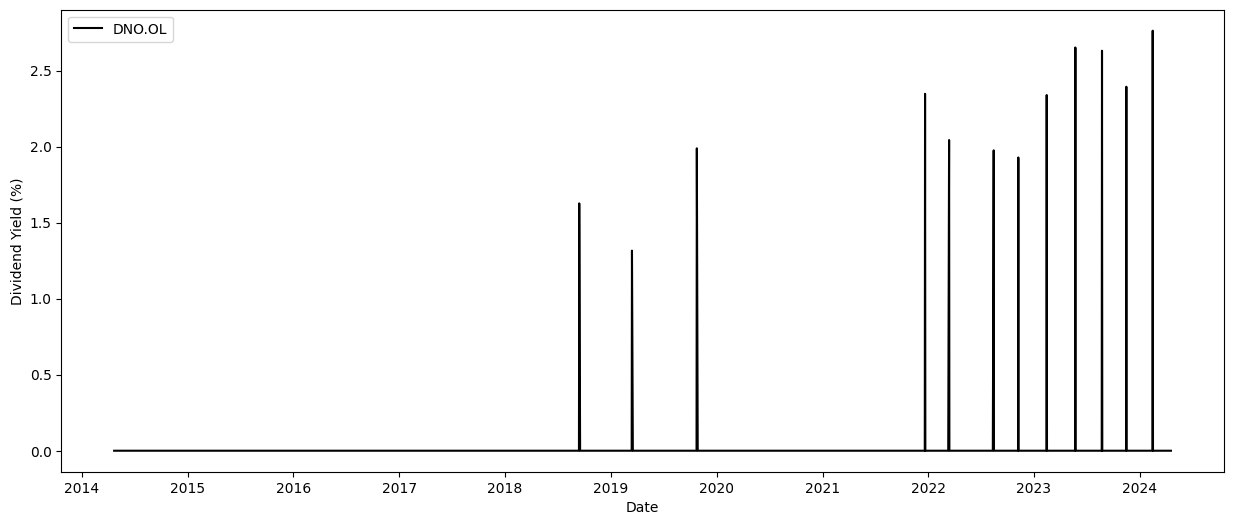

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.275501
share_price      1.000000
Name: share_price, dtype: float64


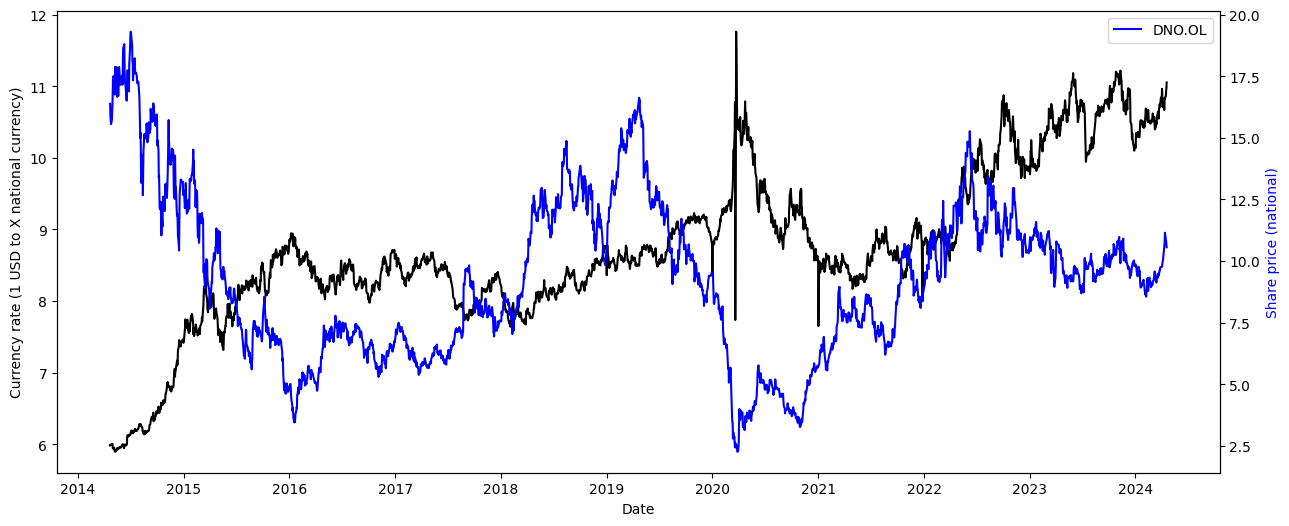

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

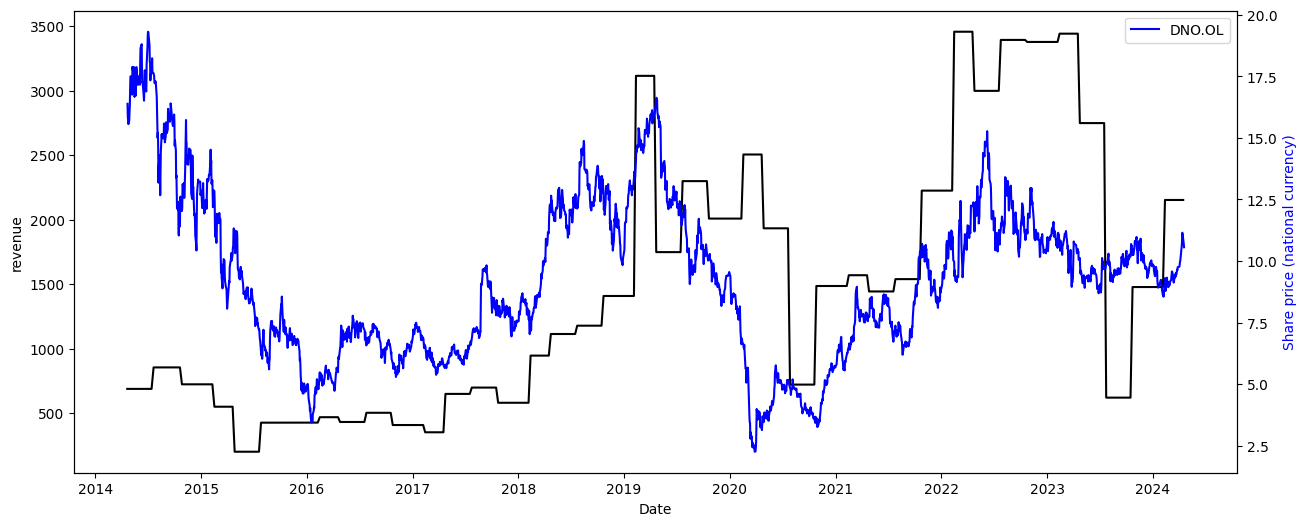

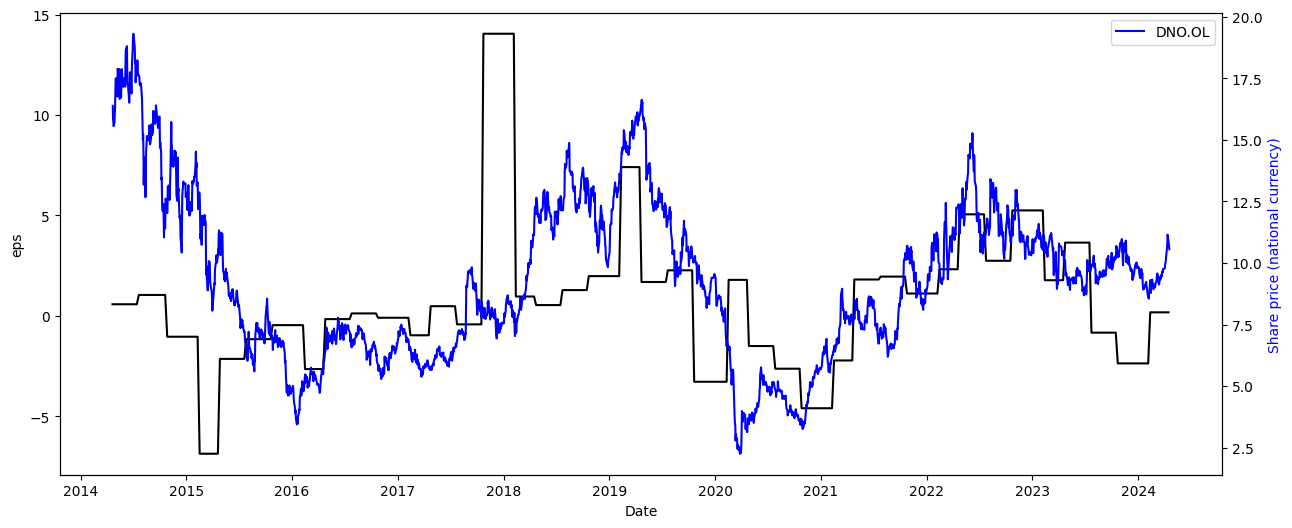

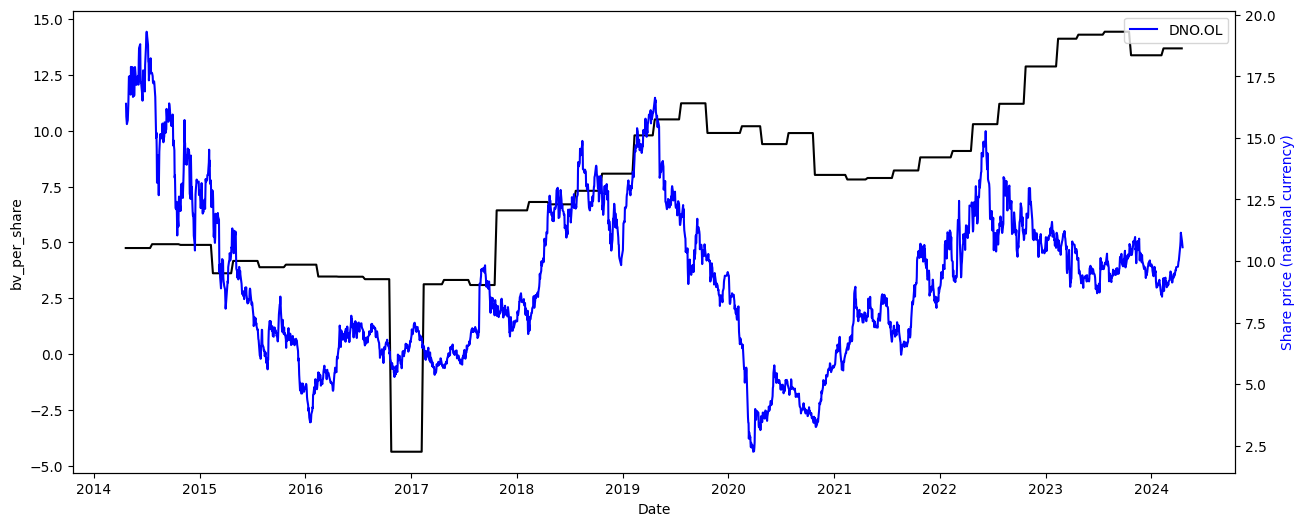

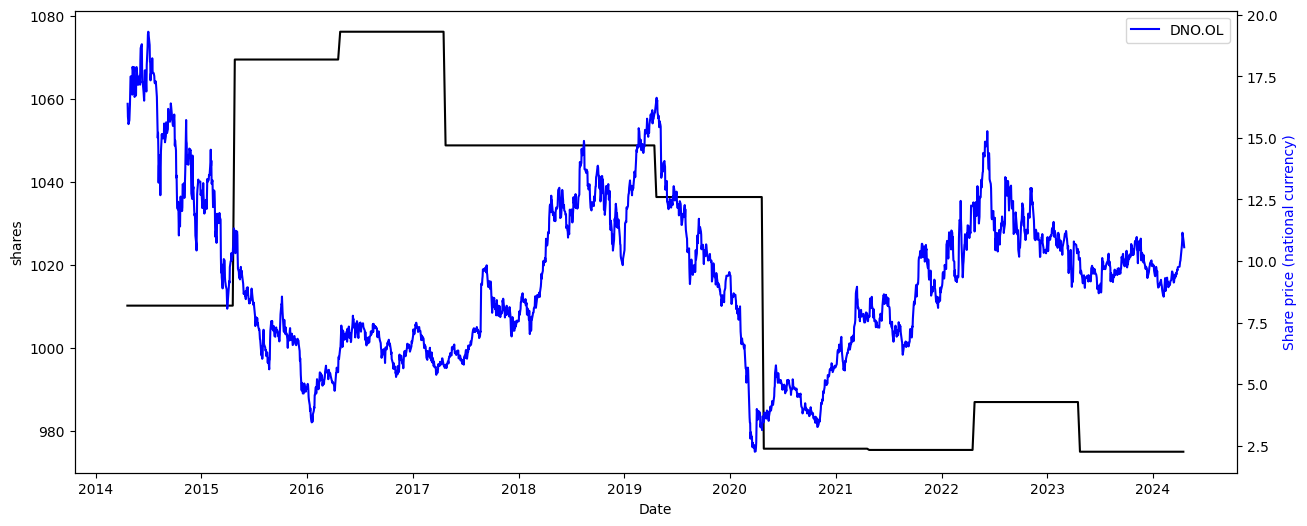

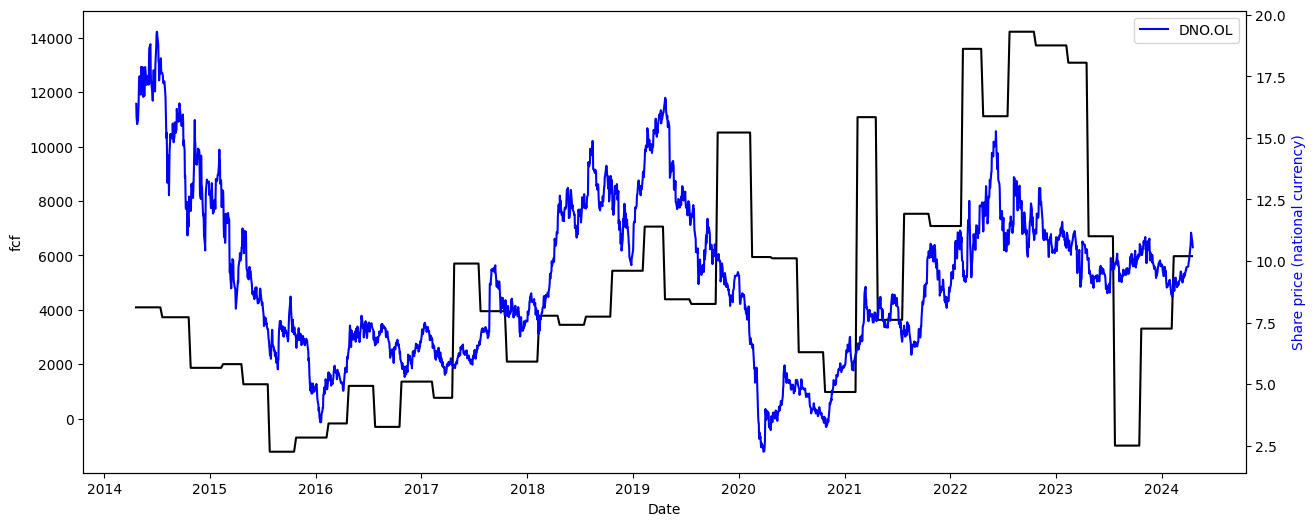

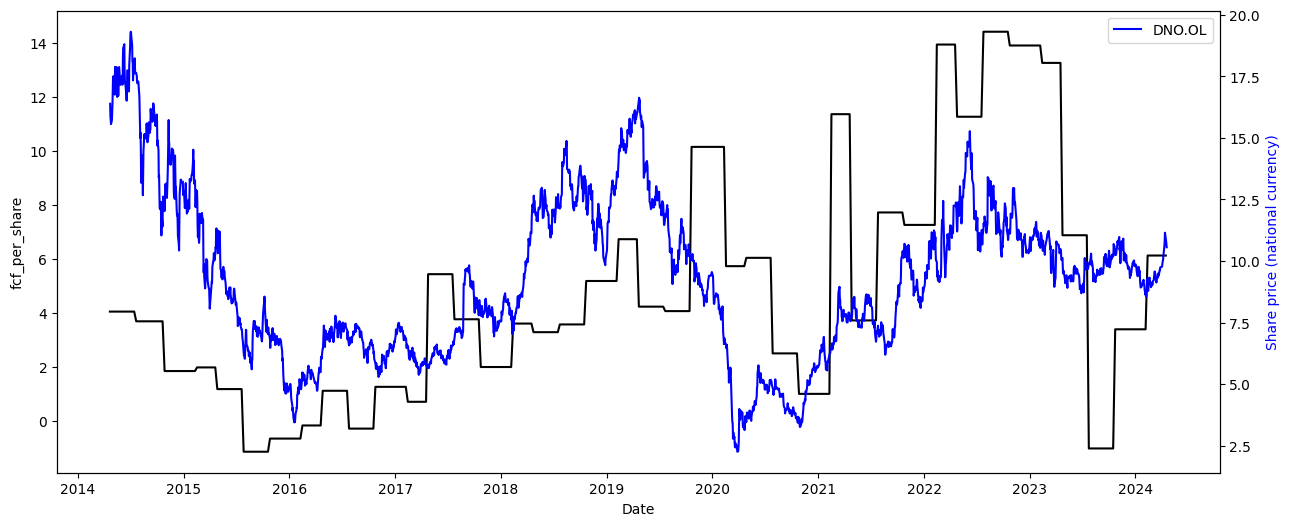

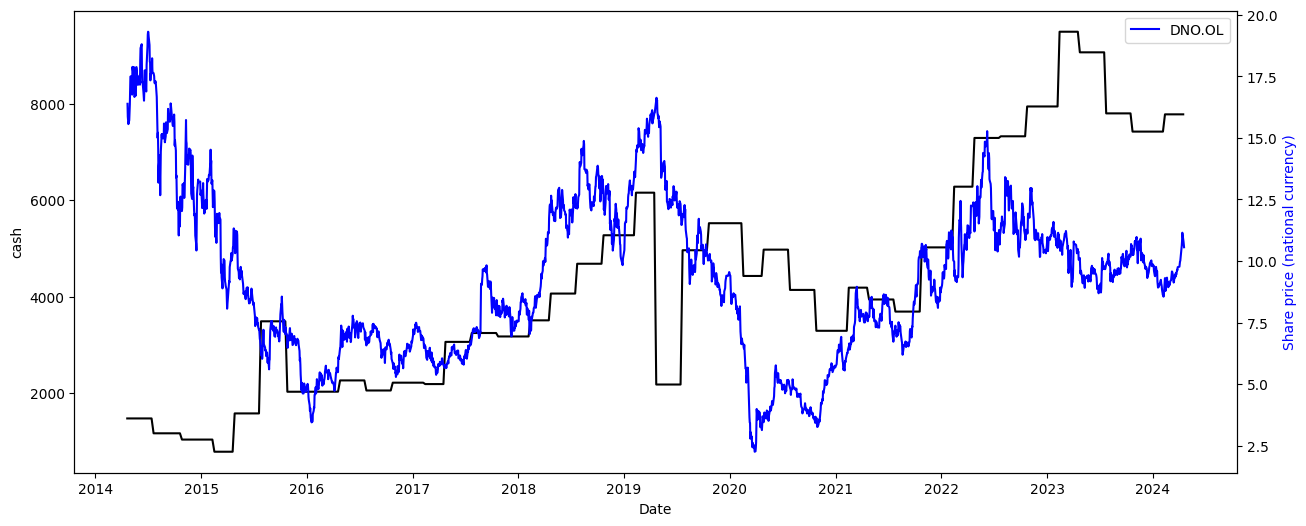

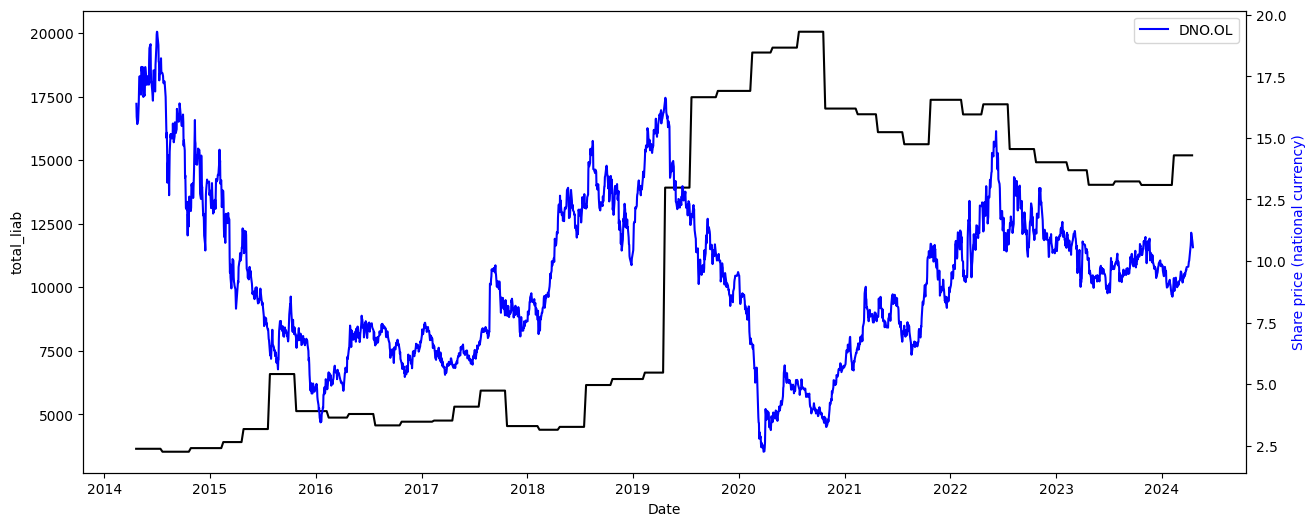

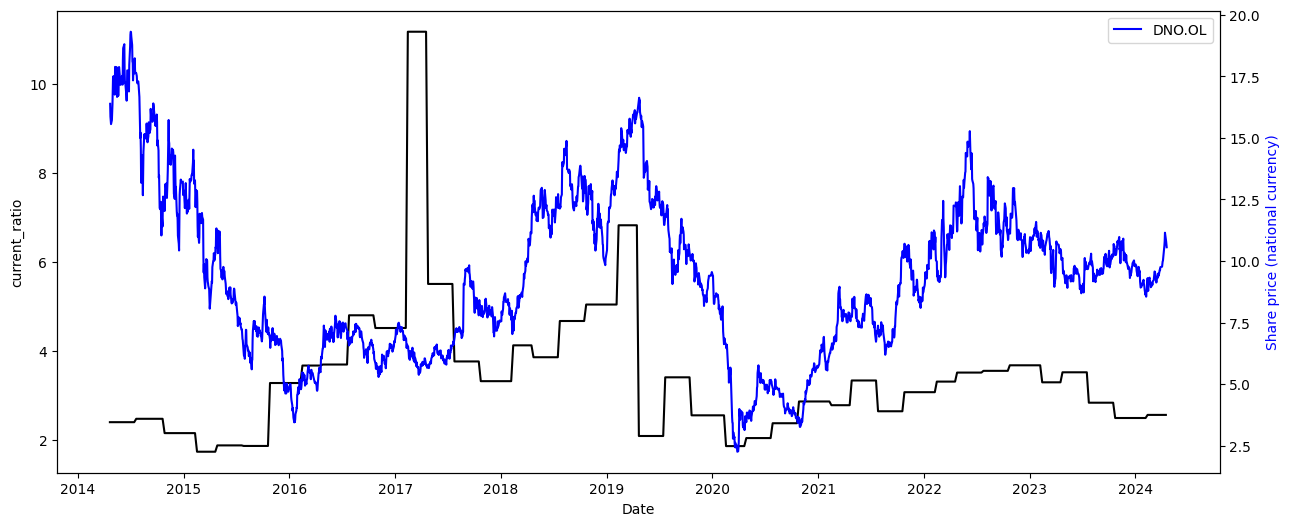

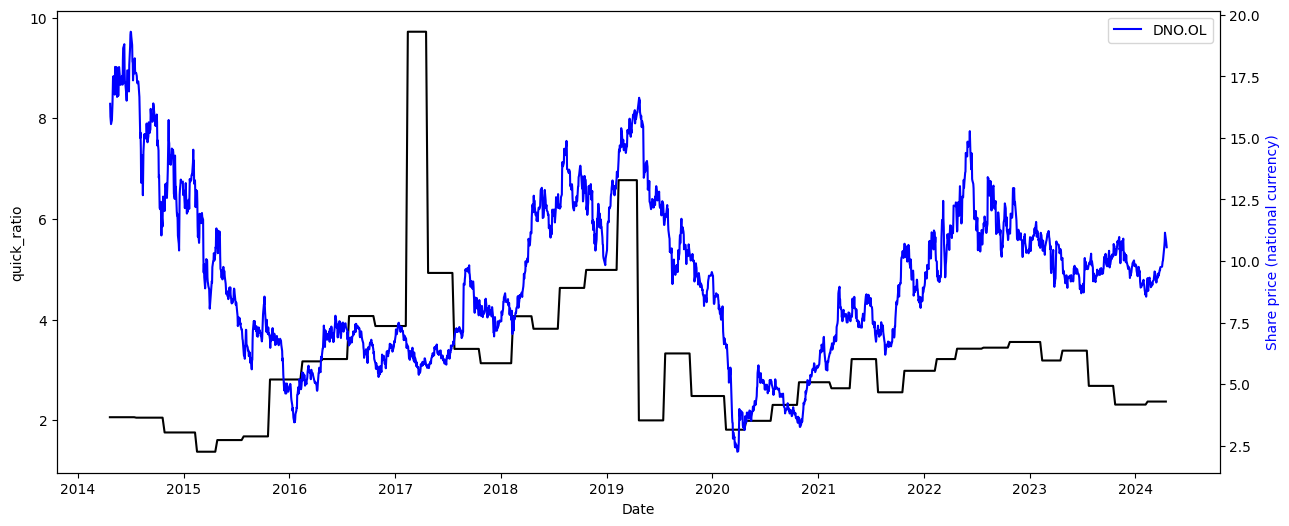

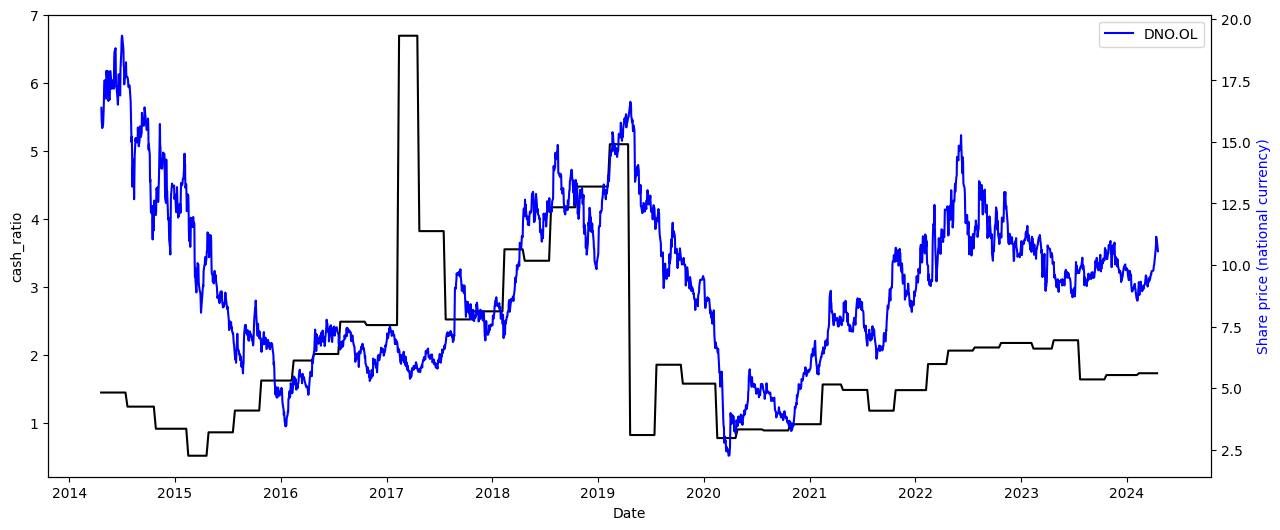

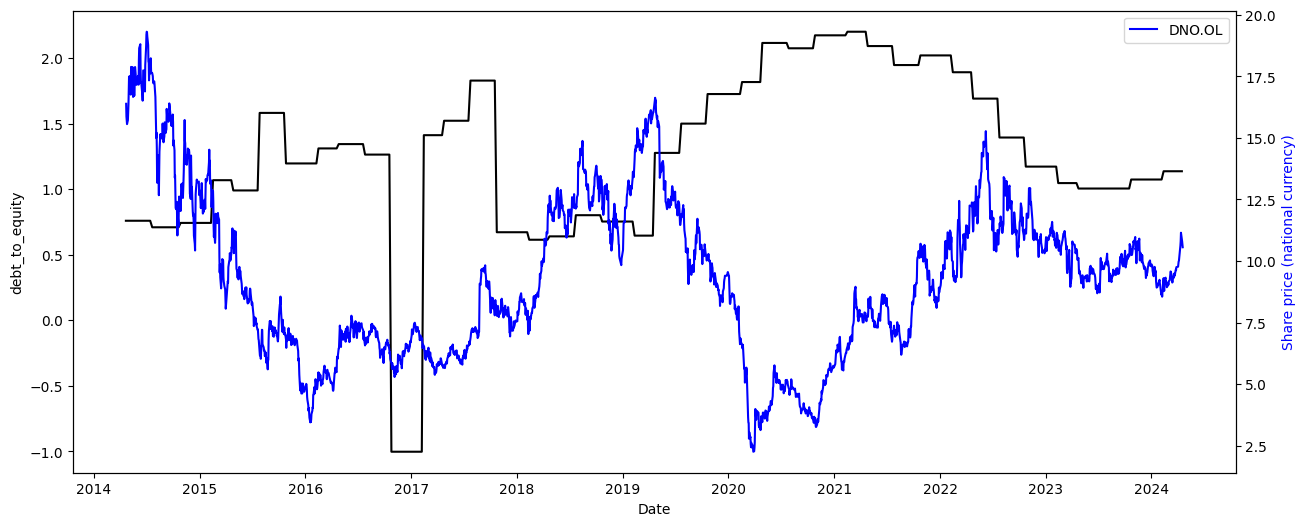

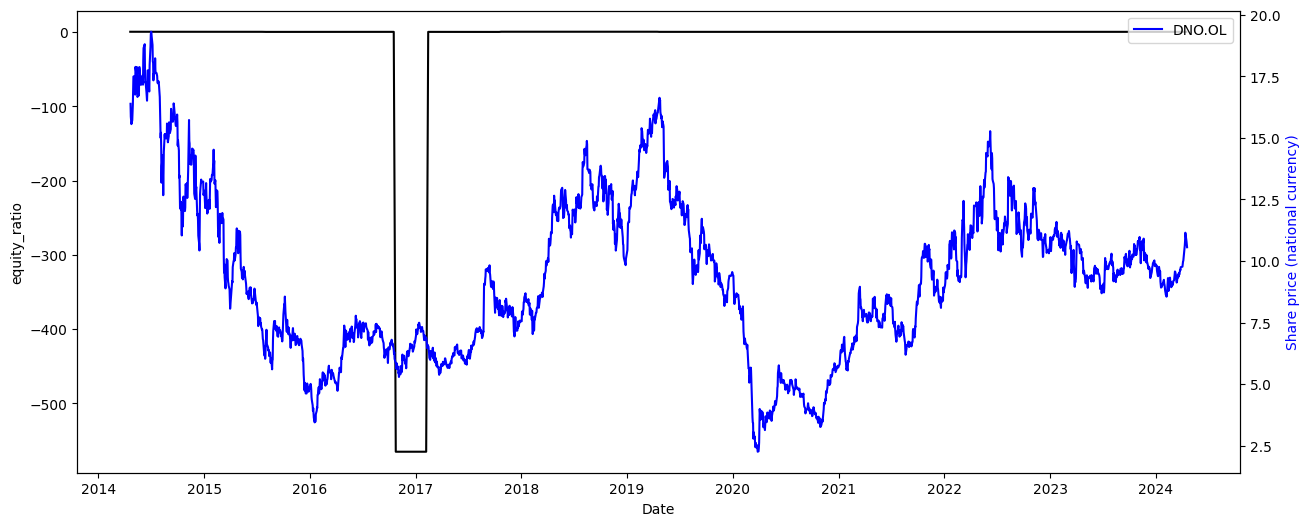

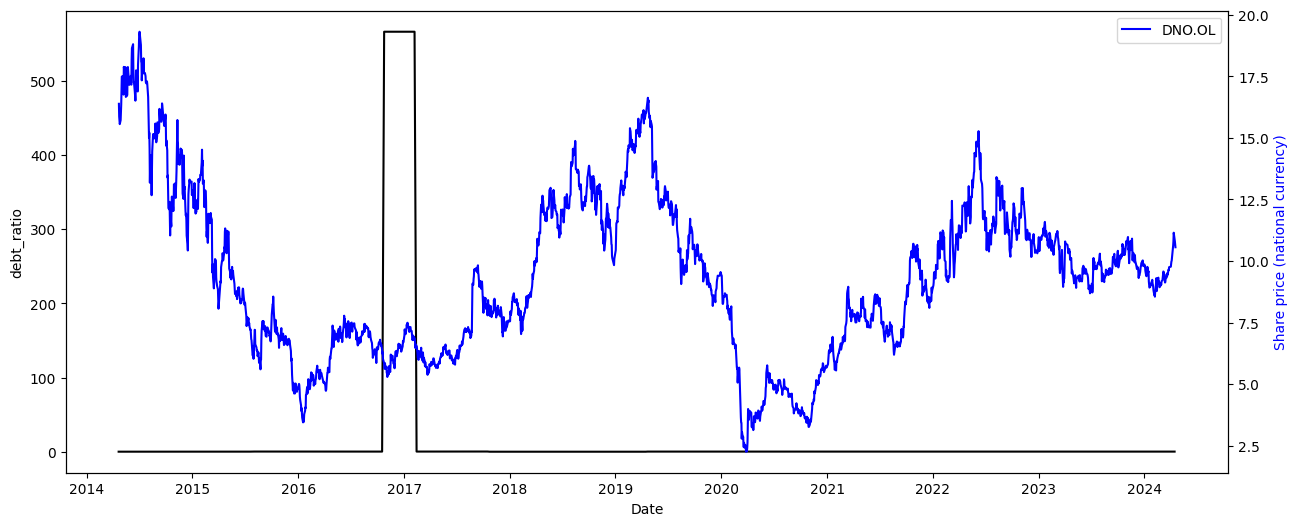

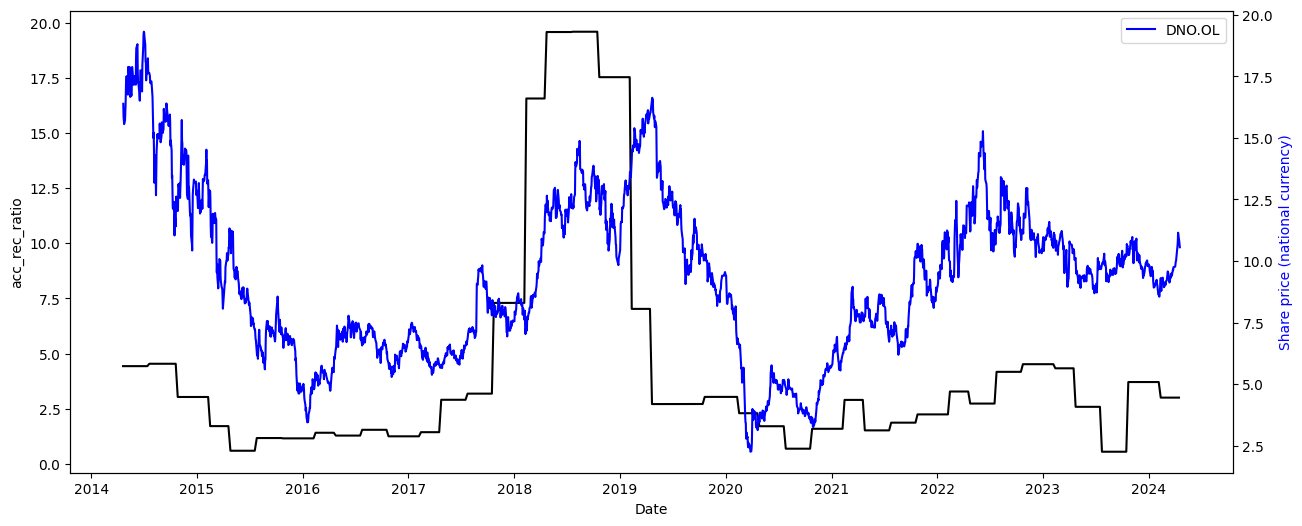

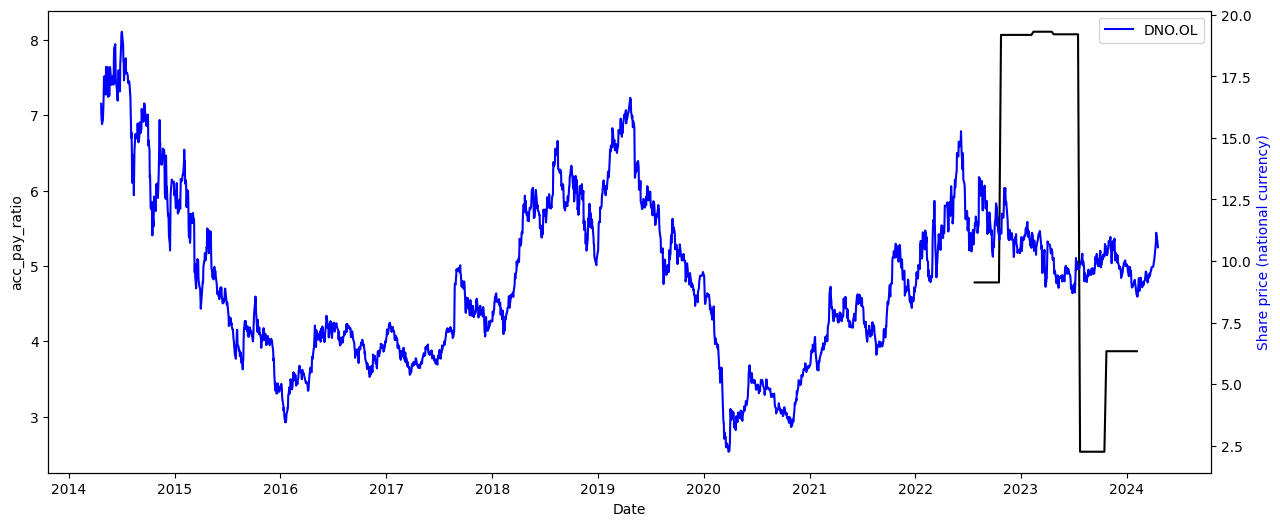

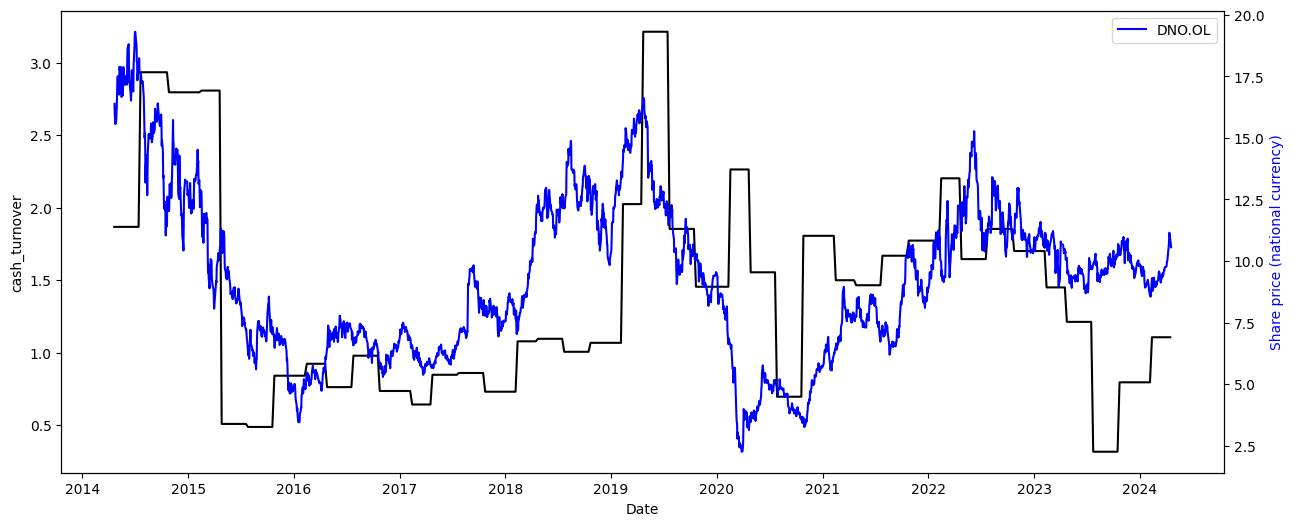

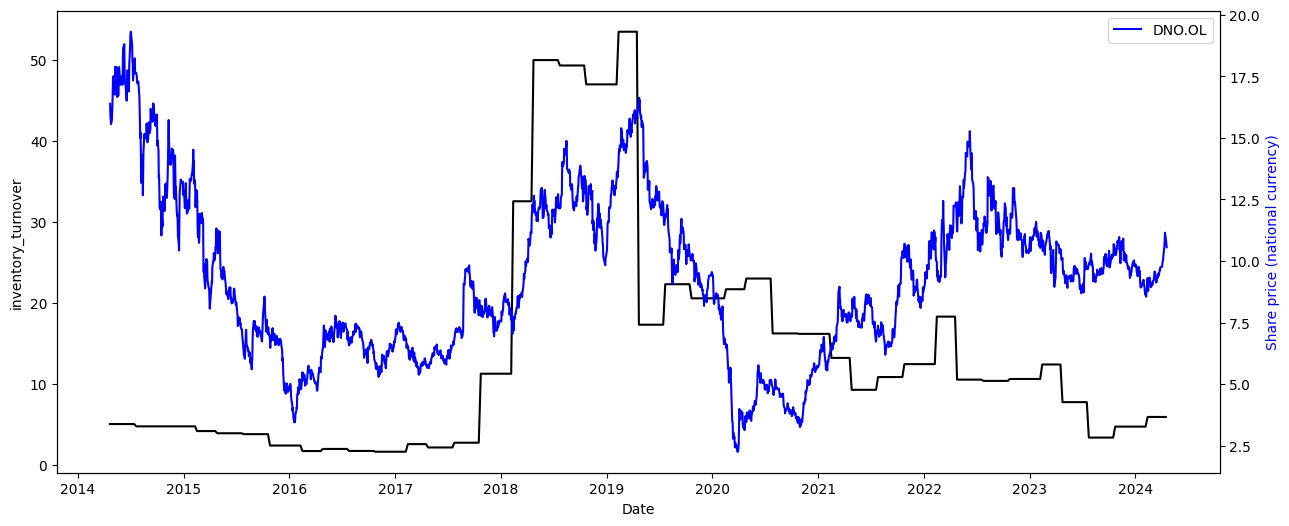

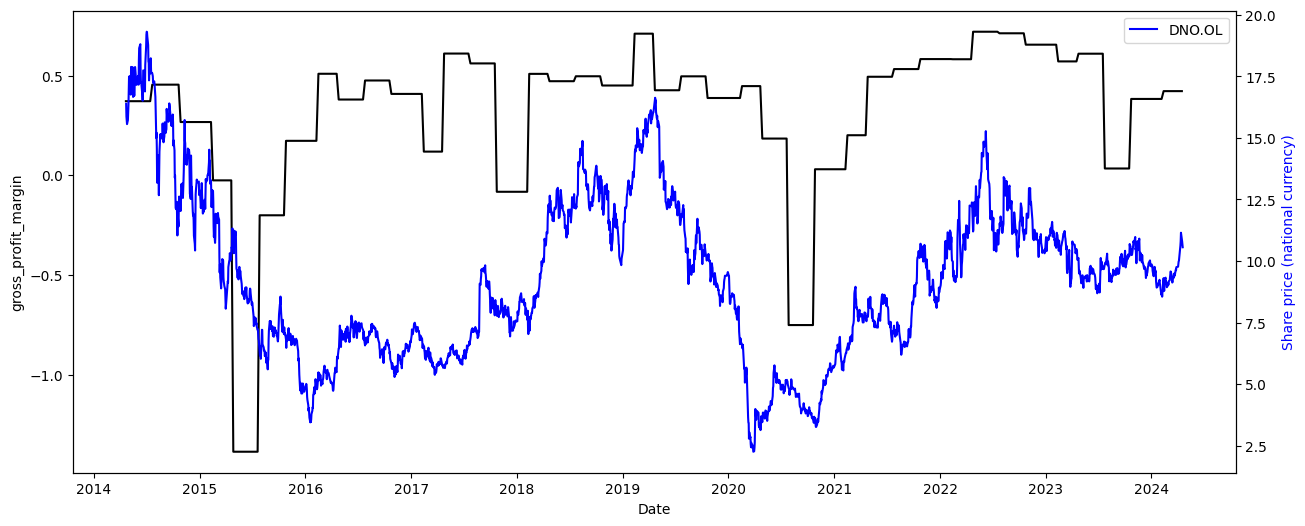

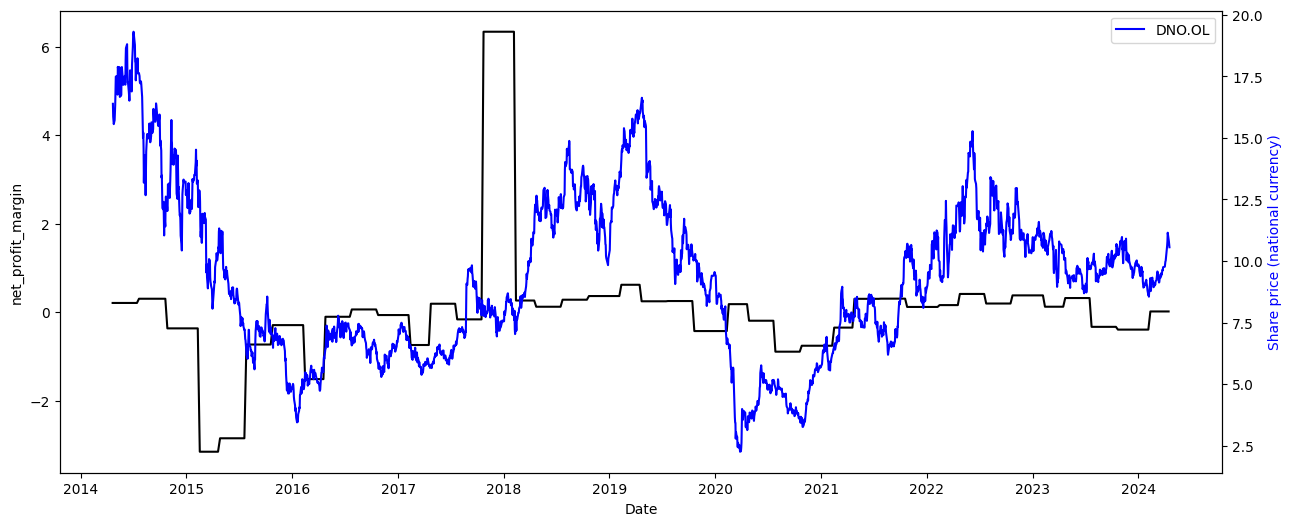

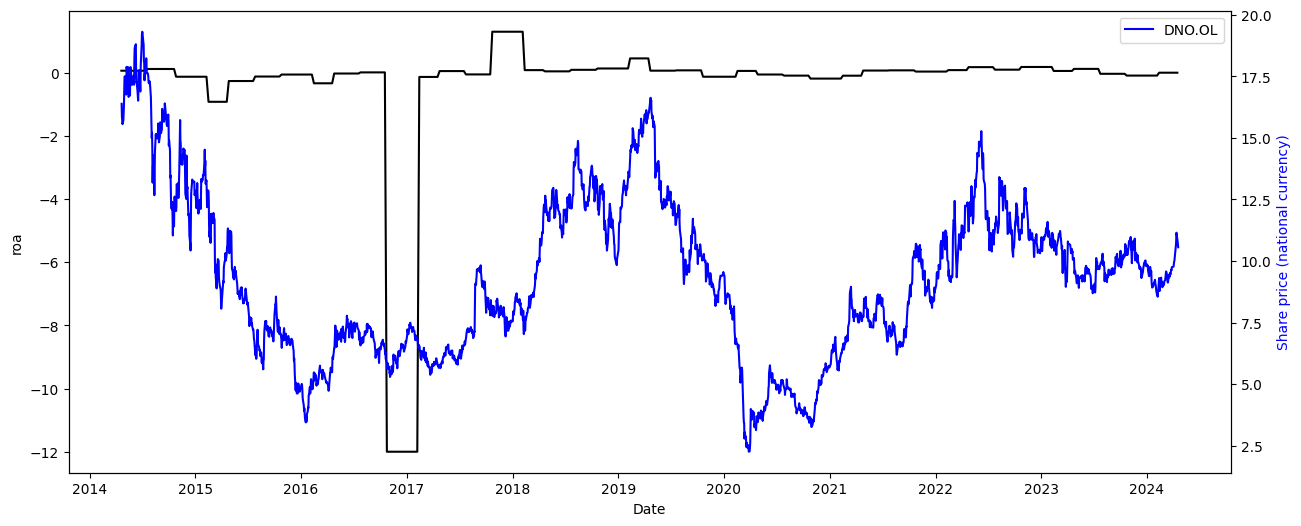

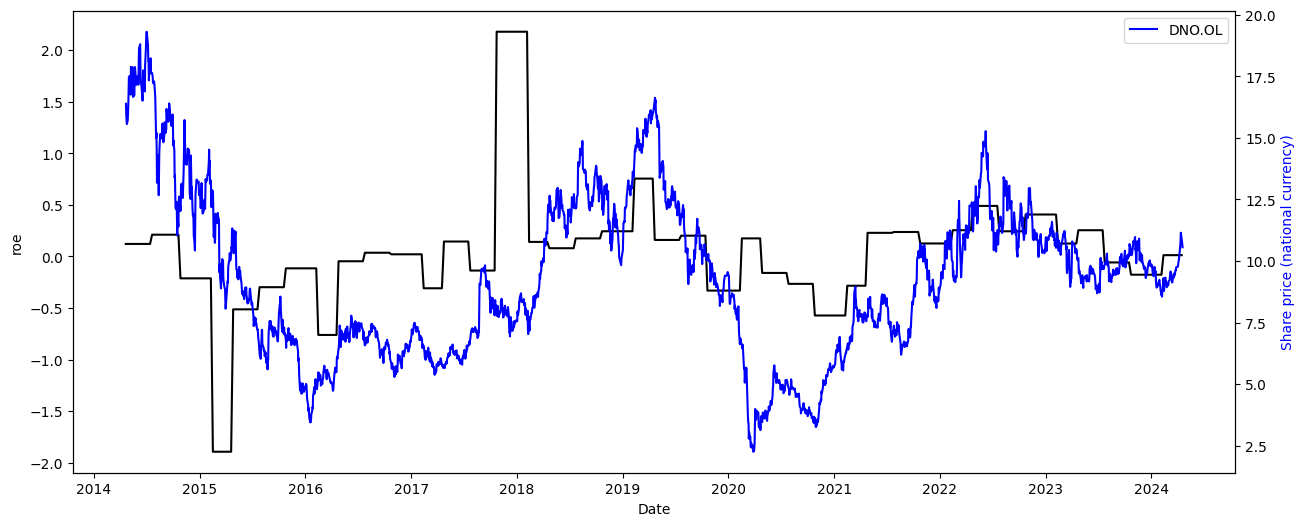

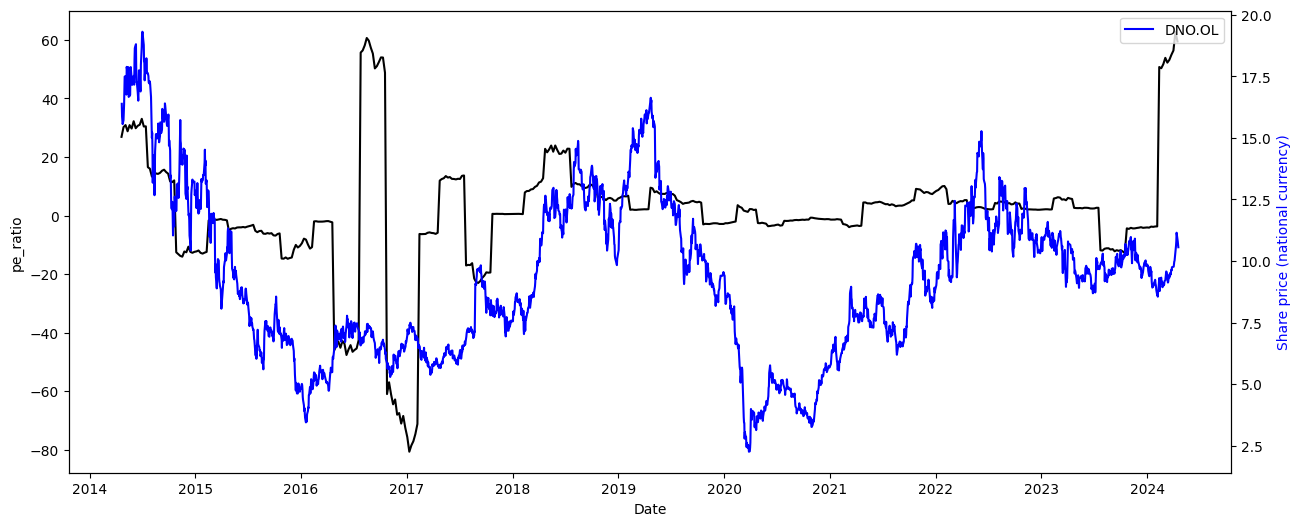

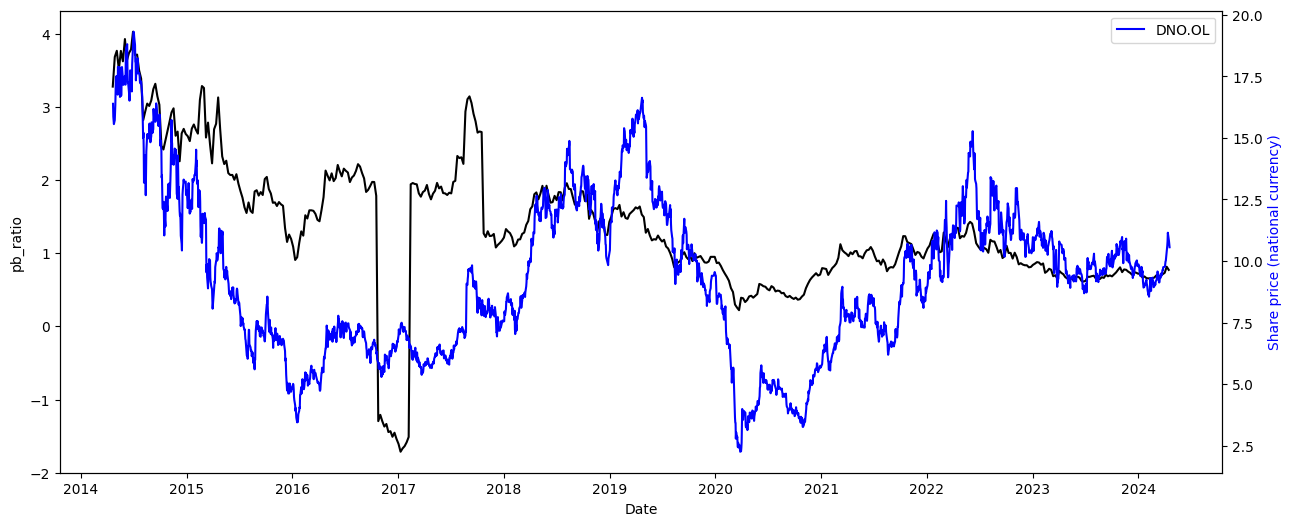

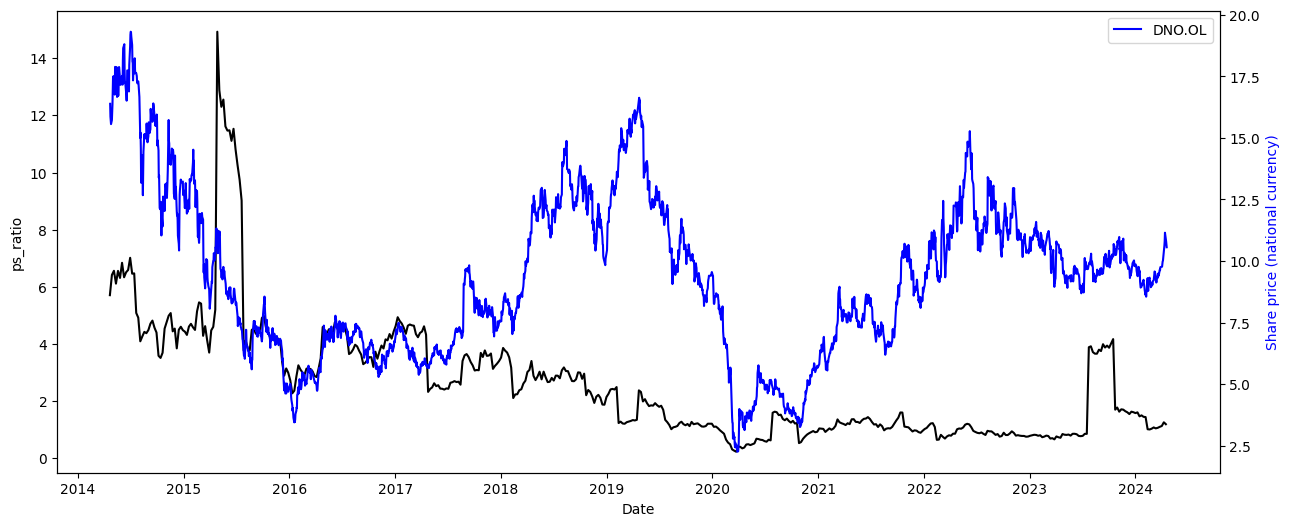

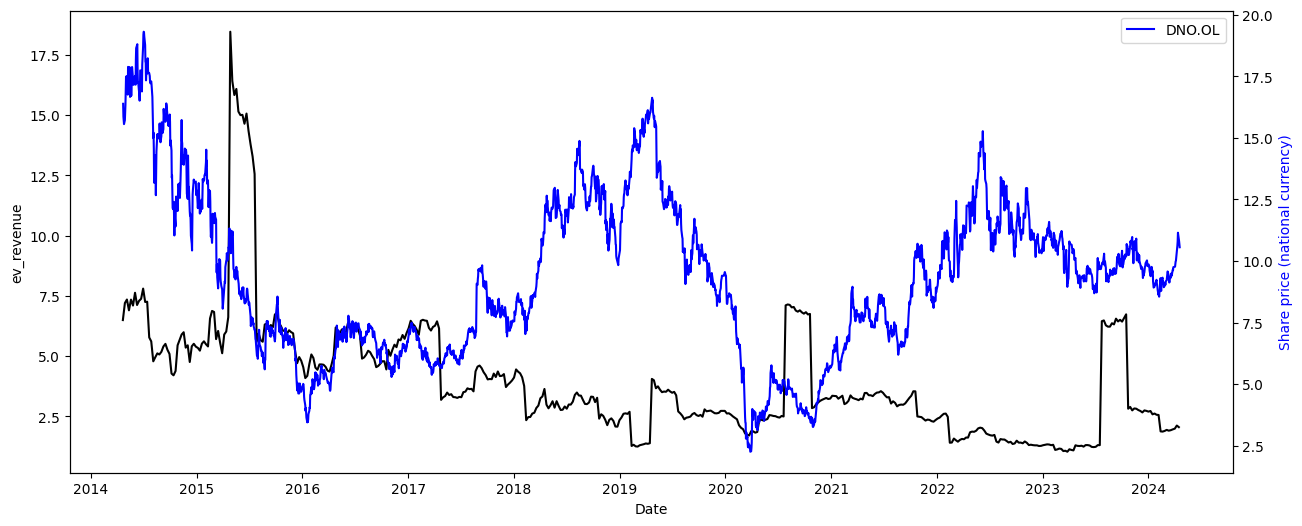

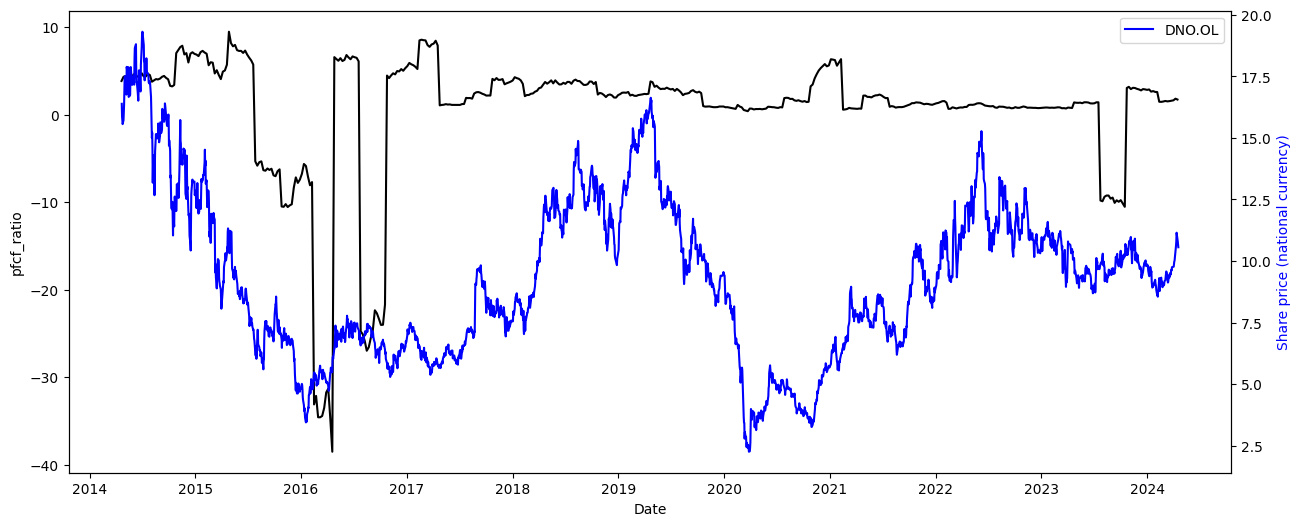

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

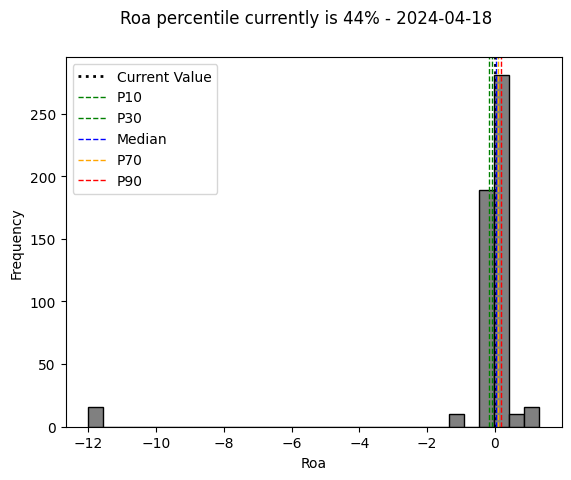

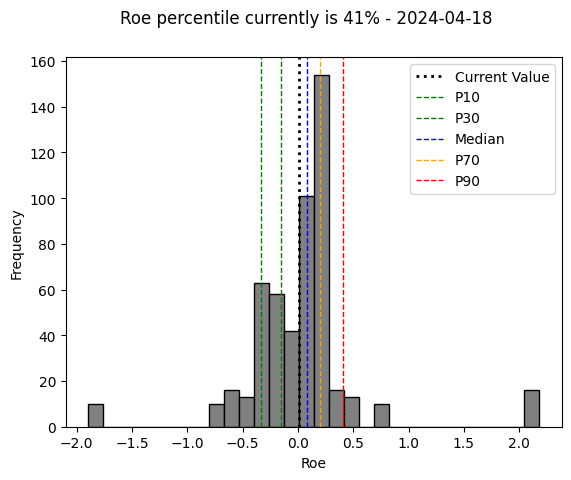

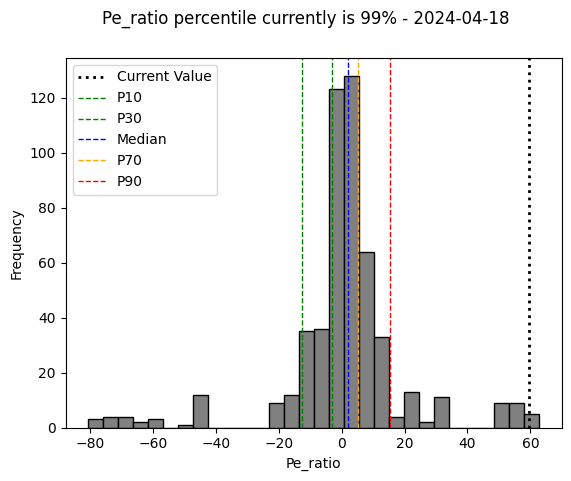

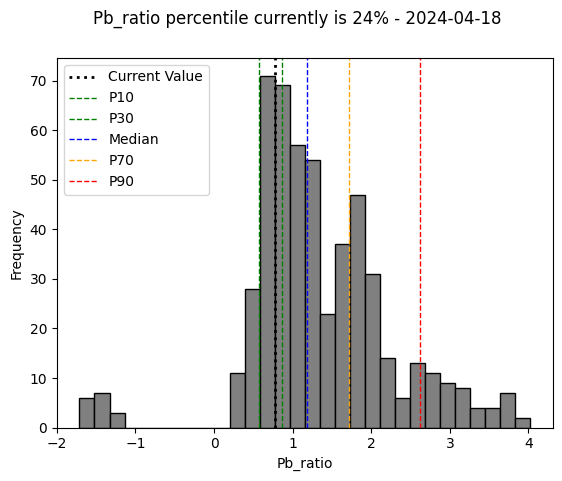

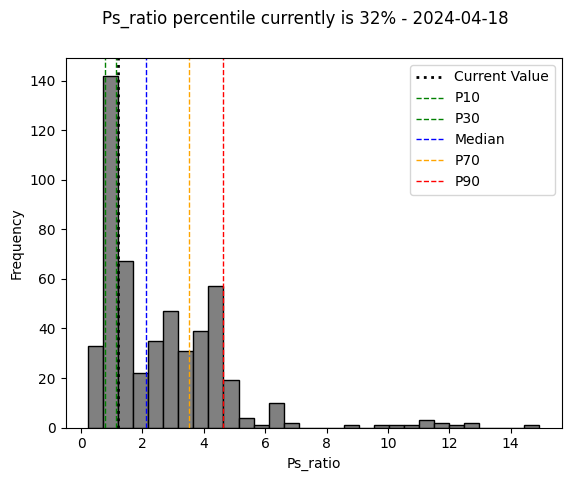

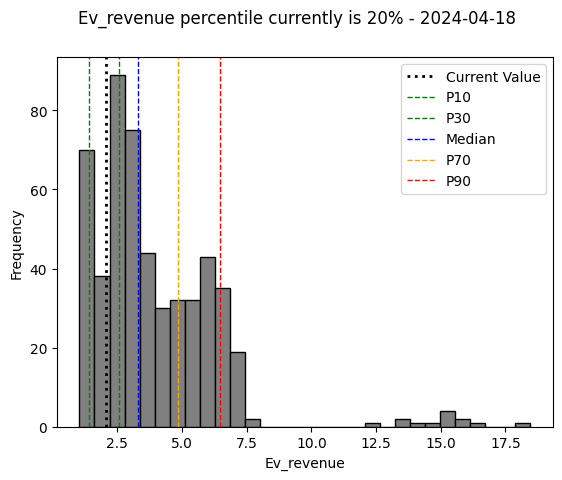

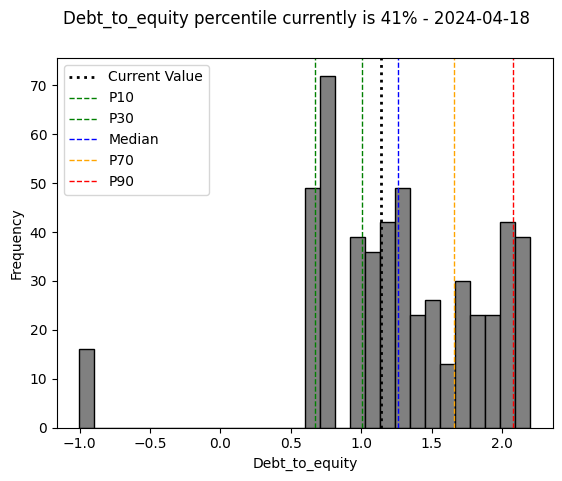

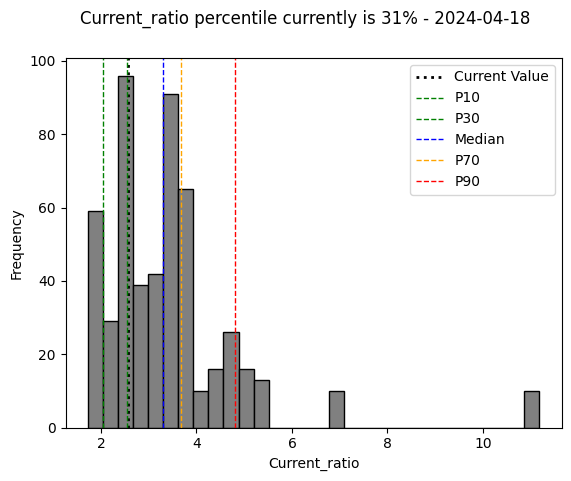

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.142709,0.619658,0.521923,-0.159736,-0.167197,0.602446,-0.105270
roe,0.142709,1.000000,0.117800,-0.131696,-0.192876,-0.315626,-0.196315,0.176052
pe_ratio,0.619658,0.117800,1.000000,0.376441,-0.158372,-0.222069,0.280342,-0.032549
pb_ratio,0.521923,-0.131696,0.376441,1.000000,0.497299,0.328331,0.061369,0.002909
ps_ratio,-0.159736,-0.192876,-0.158372,0.497299,1.000000,0.920854,-0.424050,-0.022995
ev_revenue,-0.167197,-0.315626,-0.222069,0.328331,0.920854,1.000000,-0.203698,-0.128158
debt_to_equity,0.602446,-0.196315,0.280342,0.061369,-0.424050,-0.203698,1.000000,-0.207037
current_ratio,-0.105270,0.176052,-0.032549,0.002909,-0.022995,-0.128158,-0.207037,1.000000


10 timestemos have been found!


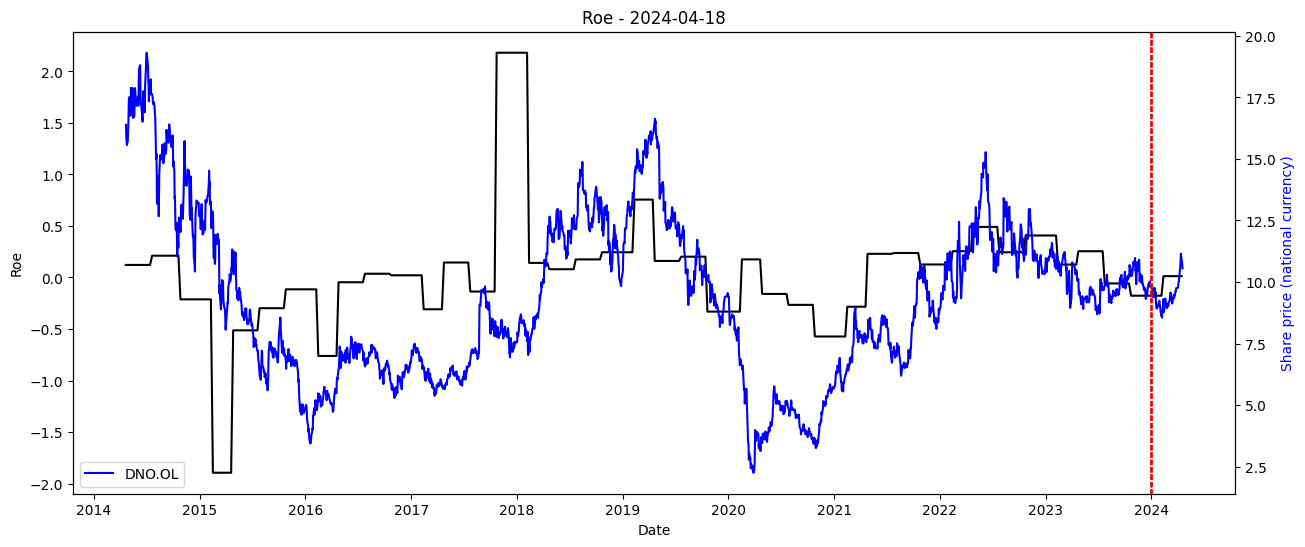

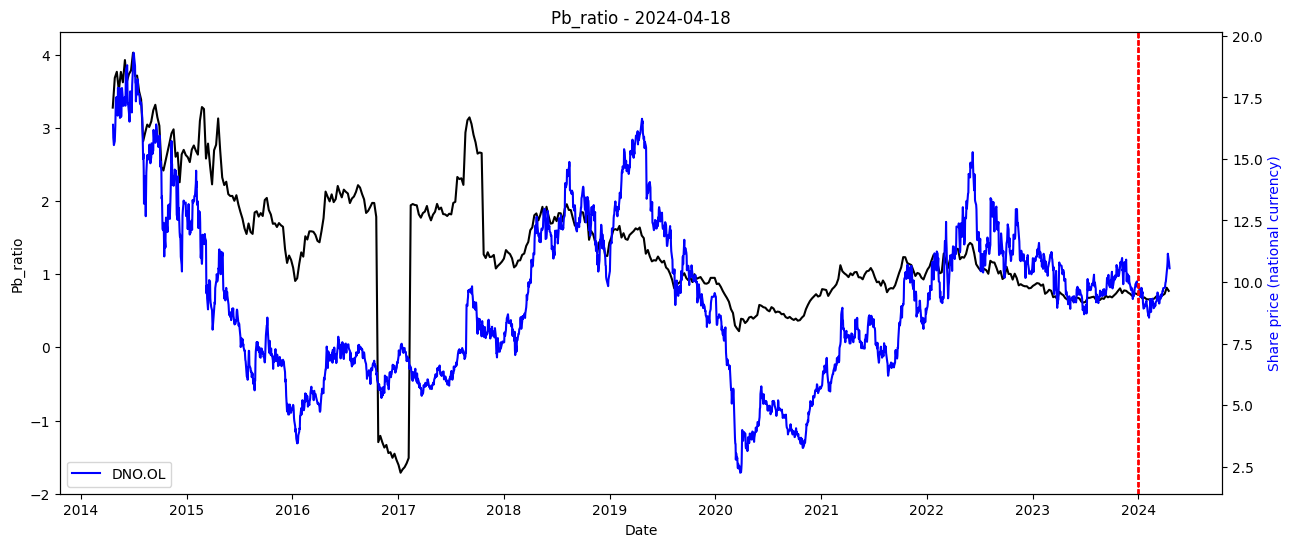

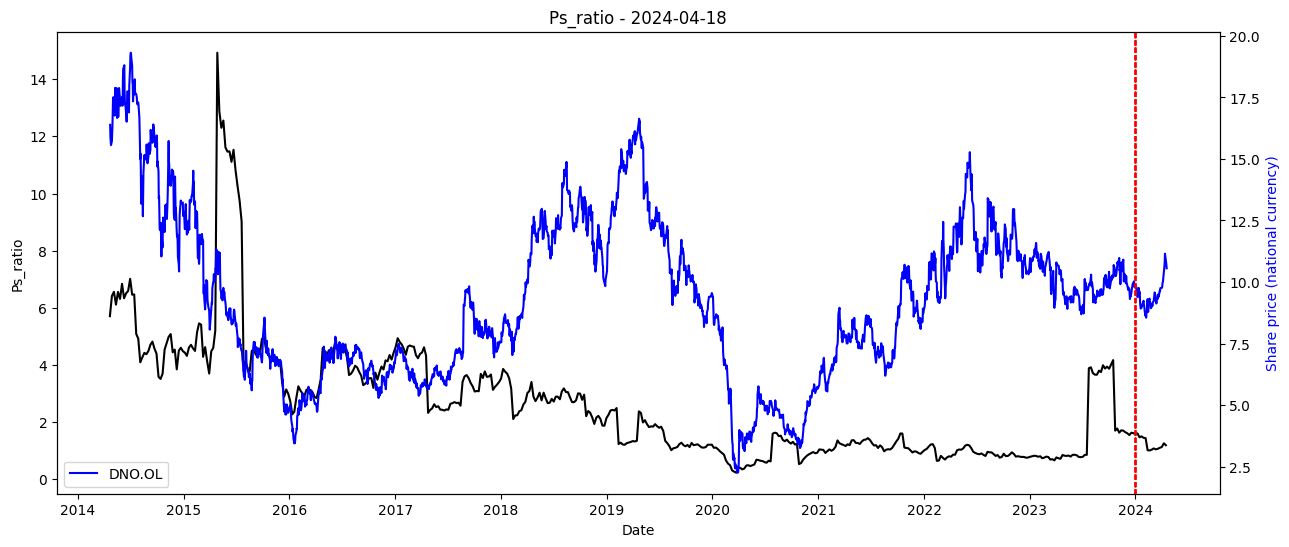

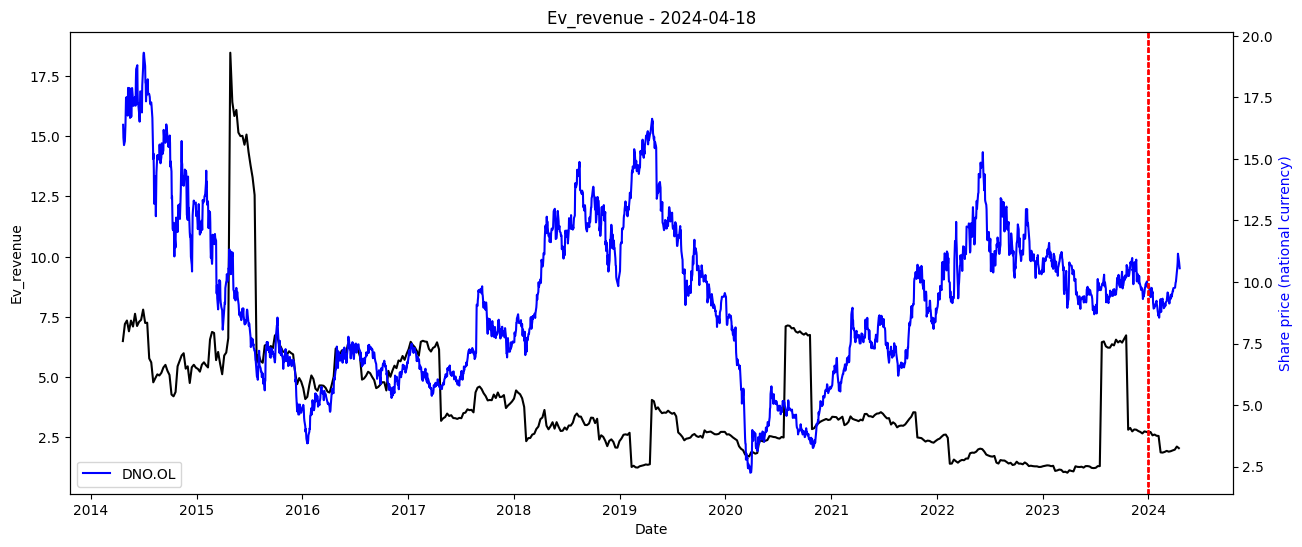

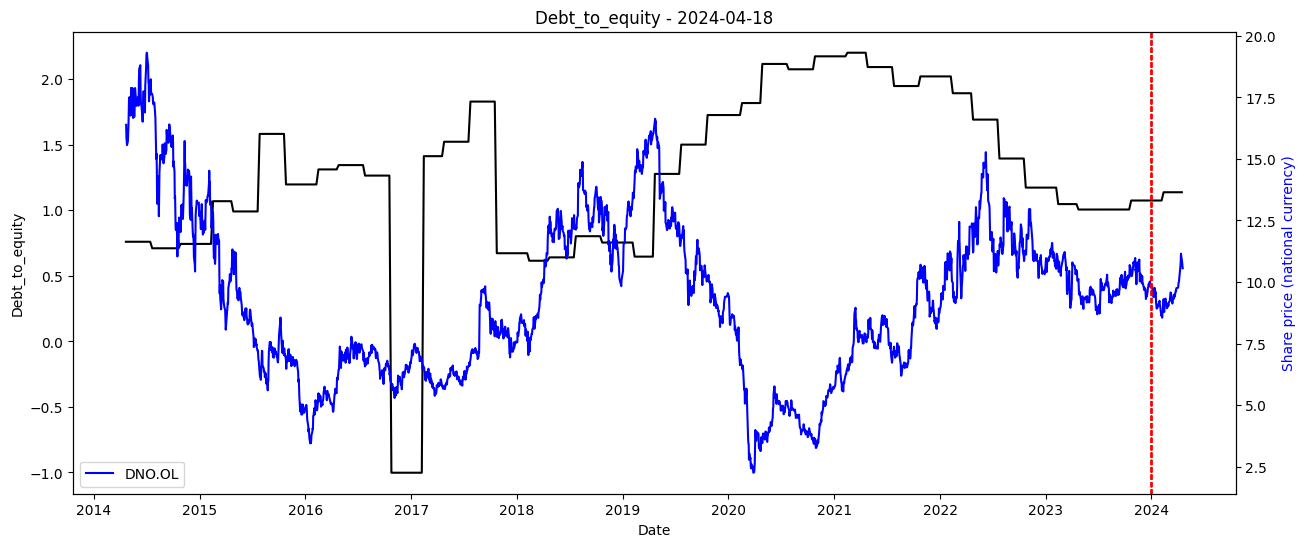

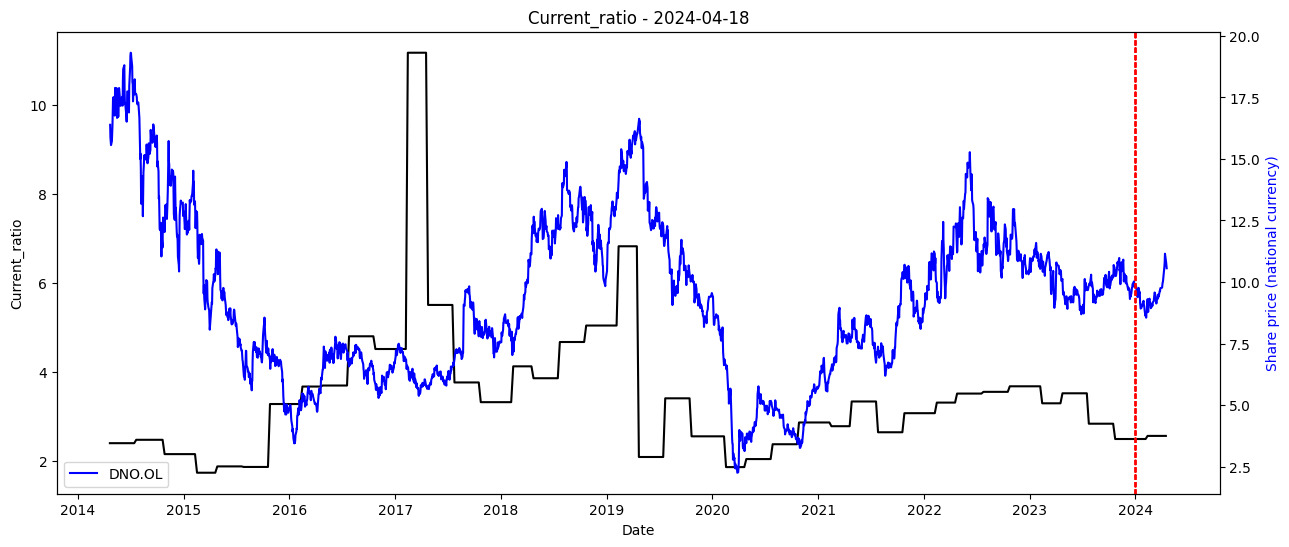

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )